Simple 2D gaussian fitting of a PSF is not working well, at all.  Splitting this
out from where I'm seeing the problem, in Sunburst_measure_line_ratios.ipynb, to its own section, so I can ask for help.  -jrigby, oct 2021

In [1]:
import jrr
import numpy as np
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.stats import gaussian_fwhm_to_sigma
import matplotlib.pyplot as plt

In [2]:
def sigmainpix_2_fwhm_inpix(sigma) :
    return(   np.round((sigma / gaussian_fwhm_to_sigma), 3))

In [3]:
# Benchmark is still iraf imexam. From Iraf imexam running on asdwebdev-sl.gsfc.nasa.gov:
# Iraf imexam fitting:                  PSF FWHM (pixels)
# Sunburst_F160Wv4_largePSF.fits (_v2)   4.8
# Michael's iraf agrees w mine.  So, need to figure out why fitting below is so broken.

The data


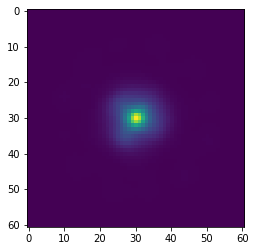

In [4]:
scaleit = 1000.  # maybe fitter is having numerical issues?
# Empirical PSF from Michael Florian, from drizzled data products, F160W PSF, from 10--12 stars
psf_file = 'Example_data/Sunburst_F160Wv4_largePSF.fits.gz'
psf_data, psf_header   = fits.getdata(psf_file,  header=True)
# https://stackoverflow.com/questions/55883497/how-do-you-extract-a-point-spread-function-from-a-fits-image
ysize, xsize = psf_data.shape  # Coax astropy.modeling.fitting into handling 2D
plt.imshow(psf_data)
print("The data")

The initialization of the fit


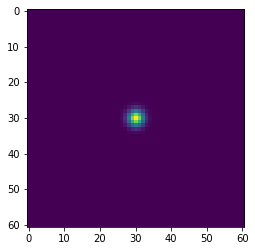

In [5]:
y, x, = np.mgrid[:ysize, :xsize]
f_init = models.Gaussian2D(0.1 * scaleit, 30., 30., 1.5, 1.5, 0.0)
fit_f = fitting.LevMarLSQFitter()
f = fit_f(f_init, x, y, psf_data * scaleit)
plt.imshow(f_init(x,y))
print("The initialization of the fit")

This fit is terrible! What's wrong?


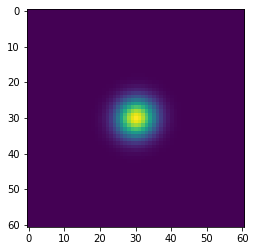

In [9]:
plt.imshow(f(x,y))  
print("This fit is terrible! What's wrong?")

In [10]:
print(f)
size = [f.x_stddev.value,  f.y_stddev.value]
print("PSF stddev:", np.round(size, 3), "pixels in x, y") 
print("This is", sigmainpix_2_fwhm_inpix(size[0]), sigmainpix_2_fwhm_inpix(size[1]), "pix FWHM") 
print("This is much bigger than what iraf imexam gets: 4.8 pix FWHM.")
print("And this fit looks terrible!")

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude           x_mean             y_mean            x_stddev           y_stddev           theta      
    ----------------- ------------------ ------------------ ------------------ ----------------- -----------------
    9.003560917473276 30.072675360857883 29.987140437766648 3.6181715742968064 3.795016852070611 -5.11176062916929
PSF stddev: [3.618 3.795] pixels in x, y
This is 8.52 8.937 pix FWHM
This is much bigger than what iraf imexam gets: 4.8 pix FWHM.
And this fit looks terrible!


In [8]:
gaussian_fwhm_to_sigma

0.42466090014400953